In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [3]:
__author__ = 'MacbookPro'
#%matplotlib inline
#from valence_plots import *
from plot_functions import *
import time
# ha
import matplotlib
matplotlib.rcParams['backend'] = 'TkAgg'
% matplotlib inline

In [4]:
# functions 

def calculate_da_app(t):
    global da_app_v, da_gtotal, da_app_gex, da_app_ginh, da_dgex
    if t > reward_start and t < reward_end:
        da_app_gex =  da_app_gex*exp_fac + int ( (np.random.rand() > 0.90)) * da_dgex * 0.1
    else:
        da_app_gex =  da_app_gex*exp_fac
    #feedback loop
    #da_ginh = da_ginh * exp_fac + (m4_v ==m4_vrest)*m4_dginh
    mtr_da_ginh[t % m_duration] =da_app_ginh
    mtr_da_gex[t % m_duration] = da_app_gex
    da_app_gtotal = da_gleak + da_app_gex + da_app_ginh
    taueff = da_cm/da_app_gtotal
    da_app_vinf = (da_gleak * da_vrest + da_app_gex * da_vex + da_app_ginh * -70) / da_app_gtotal
    da_app_v = da_app_vinf+ (da_app_v - da_app_vinf ) * np.exp ( -dt / taueff)
    if da_app_v > da_vth:
        da_app_v = da_vrest
        mtr_da_app_v[(t-1) % m_duration ] = 0
        
def calculate_da_ave(t):
    global da_v , da_vinf, da_gtotal, da_gex, da_ginh, da_dgex
    if t > punishment_start and t < punishment_end:
        da_ave_gex =  da_ave_gex*exp_fac + int ( (np.random.rand() > 0.90)) * da_dgex * 0.1
    else:
        da_ave_gex =  da_ave_gex*exp_fac
    #feedback loop
    #da_ginh = da_ginh * exp_fac + (m4_v ==m4_vrest)*m4_dginh
    da_ave_gtotal = da_gleak + da_ave_gex + da_ave_ginh
    taueff = da_cm/da_ave_gtotal
    da_app_vinf = (da_gleak * da_vrest + da_ave_gex * da_vex + da_ave_ginh * -70) / da_ave_gtotal
    da_ave_v = da_ave_vinf+ (da_app_v - da_app_vinf ) * np.exp ( -dt / taueff)
    if da_ave_v > da_vth:
        da_ave_v = da_vrest
        mtr_da_ave_v[(t-1) % m_duration ] = 0
        
        
        
       
def calculate_m4(t , d_ginh):
    global w_kc_m4, mvp_gex, mvp_gotal, mvp_vinf, mvp_v, m4_gex, m4_ginh, m4_gtotal, m4_v, x_mr, y_mr, m4_spikes, mtr_m4_t , w_kc_mvp
    global mvp_spikes , color_noise, m4_noise, kcs , m4_refract, m4_dgex
    m4_gex = 1 * np.dot(w_kc_m4.transpose(), kcs[t % m_duration,:]) * m4_dgex + m4_gex * exp_fac
    if m4_refract > 0:
        m4_v = m4_vrest
        m4_refract = m4_refract - 1
        #m4_gex = 0
    d_gin = 100
    m4_dginh = d_ginh
    m4_ginh = ( m4_ginh * exp_fac+(mvp_v ==mvp_vrest) * m4_dginh)
    mtr_ginh[t % m_duration] = m4_ginh
    mtr_gex[t % m_duration] = m4_gex
    m4_gtotal = m4_gleak + m4_gex+m4_ginh
    taueff = cm / m4_gtotal
    #print m4_ginh
    m4_vinf = (m4_gleak * m4_vrest + m4_gex * m4_vex + m4_ginh * -70) / m4_gtotal
    m4_v = m4_rm * m4_noise[t % m_duration] + m4_vinf +(m4_v - m4_vinf - m4_rm * m4_noise[t %m_duration] ) * np.exp(-dt / taueff)
    if m4_v > m4_vth:
        m4_v = mvp_vrest
        m4_spikes  = m4_spikes + 1
        mtr_m4_sp[t % m_duration] = 1
        mtr_m4_t.append(t)
        mtr_m4_v[(t-1) % m_duration] = 0
        m4_refract = refract_duration
def calculate_mvp(t):
    global w_kc_m4, mvp_gex, mvp_gotal, mvp_vinf, mvp_v, m4_gex, m4_ginh, m4_gtotal, m4_v, x_mr, y_mr, m4_spikes, mtr_m4_t , w_kc_mvp
    global mvp_spikes , color_noise, mvp_refract
    mvp_vrest = -60
    mvp_gex = np.dot(w_kc_mvp.transpose(), kcs[t % m_duration,:]) *mvp_dgex + mvp_gex * exp_fac
    if mvp_refract > 0:
        #mvp_gex = 0
        mvp_v = mvp_vrest
        mvp_refract = mvp_refract - 1
    mvp_gtotal = mvp_gleak + mvp_gex
    taueff = mvp_cm / mvp_gtotal
    mvp_vinf = (mvp_gleak * mvp_vrest + mvp_gex * mvp_vex ) / mvp_gtotal
    #removed membrane noise
    mvp_v = mvp_rm * color_noise[t % m_duration] + mvp_vinf + (mvp_v - mvp_vinf  - mvp_rm * color_noise[t % m_duration] ) *np.exp(-dt / taueff)
    # mvp_v = mvp_v + dt\tau_m * (   -(mvp_vrest - v) + (Ee-mvp_v) + (Ei-mvp_v)  )
    if mvp_v > mvp_vth:
        mvp_v = mvp_vrest
        mvp_spikes = mvp_spikes + 1
        mtr_mvp_v[(t-1) % m_duration] = 0
        mtr_mvp_t.append(t)
        mvp_refract = refract_duration
        mtr_mvp_sp[t % m_duration] = 1
        
        


In [12]:
# simulations constants
np.random.seed(255)
dt = 0.1 # [ms] each time step i avance 0.1 ms

total_duration  = 4 #s
odor_duration_s =3 # s
reward_duration = 1 # s


duration = total_duration*1000 / dt
m_duration = total_duration* 1000 /dt # 30.000 time steps
end = duration

start_odor = 0 #
end_odor = start_odor + odor_duration_s * 10000
reward_start = 10000
reward_end = reward_start + reward_duration*10000
n_kc = 100
n_kc_active = 50
#duration = end - start
kcs = np.zeros((m_duration,n_kc))
kcs_m4 = np.zeros((m_duration,n_kc))
kcs_mvp = np.zeros((m_duration,n_kc))
kc_spikes_t = np.zeros((n_kc))
indices = np.sort(np.random.choice(n_kc, n_kc_active, replace=False))
sp_times = np.sort(np.random.randint(low=start_odor, high=end_odor, size=(n_kc_active, 3* odor_duration_s)))
sp_times2 = np.sort(np.random.randint(low=start_odor, high=start_odor+100 / dt, size=(n_kc_active,2)))

for i in range(0, n_kc_active):
    kcs[sp_times[i],indices[i]] = 1
    kcs[sp_times2[i],indices[i]] = 1
spikes = []
for i in range(0,n_kc):
    spikes.append(list ( np.where(kcs[:,i])))
s_time = np.linspace(0,duration, duration / dt)
ind = np.random.binomial(1 , p=0.1 , size = (200, 1))
ind = ind > 0
#initialize weights 32
w_kc_mvp = np.random.random(( n_kc ))
#w_kc_m4 = np.random.random((n_kc ))
w_kc_m4 = np.ones ((n_kc, )) * 0.5
#kc_spikes = np.zeros((n_kc,4))
# mvp neuron variables
mvp_gex = 0
mvp_vrest = -60
mvp_v = mvp_vrest
mvp_spikes = 0
mvp_gtotal = 0
mvp_vinf = 0
mvp_vth = -45
mvp_dgex = 0.5
mvp_rm = 10
mvp_gleak = 1.0
mvp_vex = 0
mvp_cm = 10
m4_dgex = 0.5
cm = 10

# dopamine variables
da_vex = 0
da_vinh = -70

da_app_vinh = 0
da_app_gtotal = 0
da_app_v = 0
da_ave_vinh = 0
da_ave_gtotal = 0
da_ave_gtotal = 0


da_gleak = 1.0
da_gtotal = 0
da_app_gex = 0
da_app_ginh = 0
da_ave_gex = 0
da_ave_ginh = 0

tauexinh = 10
da_cm = 10
da_I = 2
# dopamine variables

da_vth = -45
da_rm = 10
da_vrest  = -60
da_dgex = 0.5
exp_fac = np.exp(-dt / tauexinh)
da_v = da_vrest
#m4 variables
m4_vex = 0
m4_vinh = -70
m4_vrest = -65
m4_gex = 0
m4_ginh = 0
m4_gtotal = 0
m4_spikes = 0
m4_vinf = 0
m4_vth = -45
m4_v = m4_vrest
m4_rm = 10
m4_gleak = 1.0
m4_dginh = 0.5
m_m4v = np.zeros((m_duration))
mtr_m4_t = []

mvp_wstdp = np.zeros((n_kc,1))
m4_dgex = 0.5
dginh = 0.5
#m_mvp_v = np.zeros((len(time,1)))

mvp_xmr = 0
mvp_ymr = 0
#stdp variables
m4_xmr = 0
m4_ymr = 0
d_da_app = 0
d_da_ave =  0
tau_p = 30
tau_min =20
a_min = 0.5
a_plus =0.5
mtr_mvp_t = []
s1 = time.time()
start_stim = 0
end_stim = 100000
m4_spikes = 0
##### ONLY IF NEED BE ####

color_noise = colored_noise(50, dt, m_duration)
color_noise = scale_linear_bycolumn(color_noise, -2, 5.3)
m4_noise = colored_noise(50, dt, m_duration)
#v2_noise = colored_noise(50, Network.dt, Network.duration)
m4_noise = scale_linear_bycolumn(m4_noise, -1, 5)
#DEBUG STDP
mtr_ymr = np.zeros((m_duration ,))
mtr_xmr = np.zeros((m_duration ,n_kc))
m4_refract = 0
mvp_refract = 0
refract_duration = 20

# monitors
mtr_da_ginh = np.zeros((m_duration))
mtr_da_gex = np.zeros((m_duration))
mtr_w_m4= np.zeros((m_duration ,n_kc))
mtr_w_mvp= np.zeros((m_duration ,n_kc))
mtr_ginh = np.zeros((m_duration))
mtr_gex = np.zeros((m_duration))
mtr_m4_v= np.zeros((m_duration ))
mtr_mvp_v = np.zeros((m_duration ))
mtr_m4_sp = np.zeros((m_duration ))
mtr_mvp_sp = np.zeros((m_duration ))

mtr_m4_sp_aver = np.zeros((m_duration ))
mtr_mvp_sp_aaver = np.zeros((m_duration ))
mtr_da_app_v = np.zeros((m_duration))
mtr_da_ave_v = np.zeros((m_duration))
mtr_dda_app = np.zeros((m_duration))


rates_before_m4 = np.zeros_like(mtr_m4_sp)
rates_after_m4 = np.zeros_like(mtr_m4_sp)
rates_after_m4_aversive = np.zeros_like(mtr_m4_sp)

rates_before_mvp = np.zeros_like(mtr_m4_sp)
rates_after_mvp_app = np.zeros_like(mtr_m4_sp)
rates_after_mvp_ave = np.zeros_like(mtr_m4_sp)

#time.sleep(1.0)

stdp_on = 1
w_mvp = []
w_m4 = []
d_ginh = 0.5
mvp_dgex = 0.5
syns = [4,5]
SAVE_PLOTS = 1
restart_t =  0
sp = 0
#sp = np.zeros((duration ))
mvp_spikes = 0
m4_spikes = 0
if len(w_mvp) >0:
    w_kc_mvp = w_mvp
if len(w_m4) > 0:
    w_kc_m4 = w_m4
else:
    #w_kc_m4 = np.random.random((n_kc ))
    w_kc_m4 = np.ones((n_kc )) * 0.5
color_noise = colored_noise(50, dt, duration)
mtr_m4_v[:] = m4_vrest
mtr_m4_sp[:]  = 0
mtr_gex[:]  = 0
m4_noise = colored_noise(50, dt, duration)
m4_noise = scale_linear_bycolumn(m4_noise, -2, 5.3)
# odor exposure
rates_before_m4 = np.zeros_like(mtr_m4_sp)
rates_after_m4 = np.zeros_like(mtr_m4_sp)
rates_after_m4_aversive = np.zeros_like(mtr_m4_sp)

rates_before_mvp = np.zeros_like(mtr_m4_sp)
rates_after_mvp_app = np.zeros_like(mtr_m4_sp)
rates_after_mvp_ave = np.zeros_like(mtr_m4_sp)
n_trials = 4
#before learning measure spikes

In [ ]:
# no dopamine
fontsize = 4
fontsize_l = 9

duration_s = 3
xticks = []
xlabels = []
tick = 0
for i in range(0,total_duration*10 + 1):
    xticks.append( i*1000)
    xlabels.append(tick)
    tick = tick+0.1
    
kcs[:,:]  = 0
sp_times = np.sort(np.random.randint(low=start_odor, high=m_duration, size=(n_kc_active,2)))
sp_times2 = np.sort(np.random.randint(low=start_odor, high=start_odor+100 / dt, size=(n_kc_active,2)))
for i in range(0, n_kc_active):
    kcs[sp_times[i],indices[i]] = 1
    kcs[sp_times2[i],indices[i]] = 1
#w_kc_m4 = np.random.random((n_kc ))
#w_kc_mvp = np.random.random((n_kc ))
m4_gex = 0

mvp_gex = 0
m4_v = m4_vrest
mvp_v = mvp_vrest
mtr_m4_sp[:] = 0
d_da_app = 0
for t in range(0,int ( duration)):
    mtr_w_m4[t % m_duration] = w_kc_m4
    mtr_w_mvp[t % m_duration] = w_kc_mvp
    mtr_xmr[t % m_duration] = m4_xmr
    mtr_ymr[t % m_duration] = m4_ymr 
    mtr_dda_app[t % m_duration] = d_da_app
    mvp_vrest = -60
    calculate_mvp(t)
    mtr_mvp_v[t % m_duration] = mvp_v
    calculate_m4(t, d_ginh)
    calculate_da_app(t)
    calculate_da_app(t)
    mtr_m4_v[t % m_duration] = m4_v
    mtr_da_app_v[t % m_duration] = da_app_v
    kc_spikes_t = kcs[t % m_duration,:]
    #stdp
    d_da_app = d_da_app + dt * (-d_da_app + da_app_v == mvp_vrest)
    #d_da_ave = d_da + dt * (-d_da_ave + da_ave_v == mvp_vrest)
    d_x = kc_spikes_t
    d_y = m4_v == m4_vrest
    m4_xmr = m4_xmr + dt * (-m4_xmr / tau_p + d_x)
    m4_ymr = m4_ymr + dt * ( -m4_ymr / tau_min + d_y)
    print a_min * m4_ymr * d_x
    print a_plus * m4_xmr * d_y
    w_kc_m4 = w_kc_m4  + dt * ( -a_min * m4_ymr * d_x + a_plus * m4_xmr * d_y) 
    #w_kc_mvp= w_kc_mvp - dt * ( a_min * mvp_ymr * d_x + a_plus * x_mr * d_y) * d_da_ave
       
    ind_small = np.where ( w_kc_m4[:] < 0.1)
    ind_small = np.where ( w_kc_m4[:] < 0.1)
    w_kc_m4[ind_small]  = 0.1
    w_kc_mvp[ind_small]  = 0.1

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

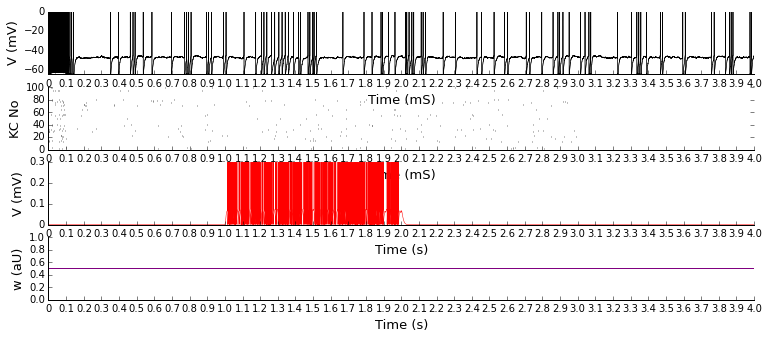

In [10]:
#what to plot
fontsize = 10
fontsize_l = 13

duration_s = 3
xticks = []
xlabels = []
tick = 0
for i in range(0,total_duration*10 + 1):
    xticks.append( i*1000)
    xlabels.append(tick)
    tick = tick+0.1
    
    
#xlabels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1 ]
#xticks = [ 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 ]

yticks =[-60,-40,-20,0]
size = (14,8)
#size = (8,8)# a4
fig = plt.figure()
fig.set_size_inches(size)
lw = 0.5
color = 'black'

fig = plt.figure();
ax1 = plt.subplot(411)
ax = plt.gca()
plt.plot(mtr_m4_v,linewidth = lw, color =color ,marker='')
plt.ylabel('V (mV)',fontsize=fontsize_l)
plt.xlabel('Time (mS)',fontsize=fontsize_l)
plt.tick_params(labelsize=fontsize)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#plt.gcf().subplots_adjust(bottom=.4,left=.2)
plt.xticks(xticks, xlabels);
plt.yticks(yticks);
plt.plot(mtr_m4_v,linewidth = lw, color =color ,marker='')


plt.subplot(412)
ax = plt.gca()
#ax.annotate('A', xy=(0, 1), xytext=(-70, 0), va='top', xycoords='axes fraction', textcoords='offset points',fontsize=30)
fig.set_size_inches(size)


for ith, trial in enumerate(spikes):
    plt.vlines(trial[0], ith + .5, ith + 1.5, color=color, linewidth = lw)
plt.ylim(.5, len(spikes) + .5)
plt.tick_params(labelsize=fontsize)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

plt.xlim([0,duration])
plt.ylabel('KC No', fontsize=fontsize_l)
plt.xlabel('Time (mS)',fontsize=fontsize_l)
plt.gcf().subplots_adjust(bottom=.4,left=.2)
#ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(xticks, xlabels);
plt.yticks([0,20,40,60,80,100]);



plt.subplot(413)
ax = plt.gca()
#fsds
fig.set_size_inches(size)
plt.plot(mtr_da_app_v,linewidth = lw, color ='red' ,marker='')
plt.ylabel('V (mV)',fontsize=fontsize_l)
plt.xlabel('Time (s)',fontsize=fontsize_l)
plt.tick_params(labelsize=fontsize)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(xticks,xlabels);
plt.yticks(yticks,xlabels);

plt.subplot(414)
ax = plt.gca()
plt.plot(mtr_w_m4[:,[1,2,3,4,5,6,7,8,9]],linewidth = lw, color ='purple' ,marker='')
plt.ylabel('w (aU)',fontsize=fontsize_l)
plt.xlabel('Time (s)',fontsize=fontsize_l)
plt.tick_params(labelsize=fontsize)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.ylim([0,1])
plt.xticks(xticks,xlabels);






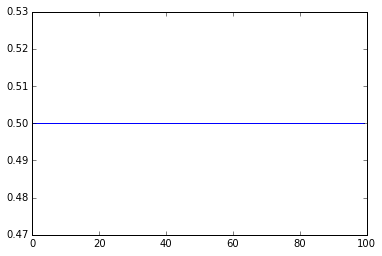

In [11]:
plt.plot(w_kc_m4)